In [1]:
!pip install scikit-learn==1.5.0
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.0 which is incompatible.


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
import torch.utils.data as data_utils
import numpy as np
import matplotlib.pyplot as plt
import optuna
import cupy as cp
from cuml.manifold import UMAP as cumlUMAP
import matplotlib.offsetbox as offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.neighbors import NearestNeighbors
import os

crear device para pytorch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Descargar el dataset y transformarlo a tensor, también lo normaliza

In [4]:
data_set = np.load('/kaggle/input/kdm-database-spiners/data.npy.npz')
print(data_set.files)

['Nest', 'L', 'rd', 'So', 'T', 'Jex', 'Jex2', 'Jex3', 'Jex4', 'Kan1', 'KanS', 'Hex', 'kd', 'KDM', 'MS']


Cuando se cargan las imagenes, se hace un reescalamiento de 39x39 a 40x40 para poder aplicar reducir y aumentar la dimensionalidad de manera simétrica en el modelo 

In [5]:
data = data_set['MS']
data.shape
data = torch.from_numpy(data).permute(0, 3, 1, 2).float()
data = F.interpolate(data, size=(40, 40), mode='bilinear')
data = data / data.max() #normalizar, queda [-1,1]
data = (data + 1) / 2 #mover rango [0,1]

se cargan las etiquetas para después pintar el espacio latente 

In [6]:
kdm = data_set['KDM']
t = data_set['T']
kdm = torch.from_numpy(kdm).float()
t = torch.from_numpy(t).float()

In [7]:
train_dataset = data_utils.TensorDataset(data, kdm, t)

train_loader = data_utils.DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=False 
)

#### La arquitectura de este VAE cuenta:
Para el encoder: se deja la función build_encoder para que durante la optimización pruebe diferentes configuraciones de capas, un flaten despues del ciclo para aplanar los datos y una densa para hallar $\mu$ y $\sigma$

Para el dencoder: una densa para aumentar la dimension de z, una unflatten para pasar de un vector a un tensor y en base al ciclo propuesto en el encoder se establece el número de capas convtranspose que requiere el decoder


Además, se define una función infer_star_dim para calcular el tamaño que tiene el tensor al final del encoder. Lo que se hace es pasar un tensor de ceros con el mismo tamaño de la imagen original a través del encoder, así, se guarda las dimensiones de la ultima capa conv para cuando se necesite hacer unflatten

In [8]:
class VAE(nn.Module):
    def __init__(self, z_dim, layers_config, device):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.layers_config = layers_config
        self.device = device
        
        # Construcción de componentes
        self.encoder = self._build_encoder(layers_config).to(self.device)
        self.flat_dim, self.h_start, self.w_start = self._infer_start_dim()
        self.fc_mu = nn.Linear(self.flat_dim, z_dim).to(self.device)
        self.fc_logvar = nn.Linear(self.flat_dim, z_dim).to(self.device)
        self.decoder = self._build_decoder().to(self.device)

    def _build_encoder(self, layers_config):
        layers = []
        in_ch = 1
        for (n_filters, use_bn) in layers_config:
            layers.append(nn.Conv2d(in_ch, n_filters, kernel_size=3, stride=2, padding=1))
            if use_bn:
                layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            in_ch = n_filters
        layers.append(nn.Flatten())
        return nn.Sequential(*layers)

    def _infer_start_dim(self):
        x = torch.zeros(1, 1, 40, 40).to(self.device)
        with torch.no_grad():
            temp_encoder = nn.Sequential(*list(self.encoder.children())[:-1]) 
            temp_encoder.eval()            
            out = temp_encoder(x)
        return out.shape[1] * out.shape[2] * out.shape[3], out.shape[2], out.shape[3]

    def _build_decoder(self):
        layers = []
        layers.append(nn.Linear(self.z_dim, self.flat_dim))
        layers.append(nn.Unflatten(1, (self.layers_config[-1][0], self.h_start, self.w_start)))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        reversed_config = list(reversed(self.layers_config))
        N_layers = len(reversed_config)
        in_ch = reversed_config[0][0] 
        for i in range(N_layers): 
            is_final_layer = (i == N_layers - 1)
            out_ch = 1 if is_final_layer else reversed_config[i+1][0] 
            use_bn = reversed_config[i+1][1] if not is_final_layer else False
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))
            in_ch = out_ch
            if not is_final_layer:
                if use_bn: layers.append(nn.BatchNorm2d(out_ch))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
            else:
                layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def get_intermediate_features(self, x):
        features = {}
        h = x
        layer_count = 1
        current_block = []
        
        for layer in self.encoder.children():
            h = layer(h)
            
            if isinstance(layer, nn.LeakyReLU):
                if layer_count <= 3: 
                    features[f'L{layer_count}'] = h.view(h.size(0), -1) 
                    layer_count += 1
                    
        return features

La función de pérdida está dada por: 


$$
L_{\text{loss}} = \frac{1}{N} \sum_{k=1}^{N} \left[ L_{\text{MSE}}(x_k, \hat{x}_k) + \beta \cdot D _{KL}(q_k || p) \right]
$$
$$
L_{loss} = \frac{1}{N} \sum_{k=1}^{N} \left( \frac{1}{D} \sum_{i=1}^{D} \left( x_{k,i} - \hat{x}_{k,i} \right) ^2 \right)  +  \beta \cdot \sum _{k=1}^{N} \left( \sum _{j=1}^{Z}{(-0.5(1 + \log (\sigma^2 _{k,j}) - \mu^2 _{k,j} - \sigma ^2 _{k,j})}) \right) 
$$
Donde, $$N= \text{tamaño del batch, } D= \text{numero de pixeles (1 * 40 * 40), } Z = \text{dimension de z, } \beta = \text{peso de la KLD}$$

In [9]:
def loss_function(x_hat, x, mu, logvar, beta):
    x_hat = torch.clamp(x_hat, min=1e-5, max=1-1e-5)
    MSE = F.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = (MSE + beta * KLD) / x.size(0)
    return loss, MSE, KLD

A diferencia del anterior cuadernillo, se va aplicar bayes optimización (con la librería optuna) para encontrar los mejores hiperparametros para esta red. En este caso se quiere optimizar:
- lr: learning rate
- z_dim: dimensión del espacio latente
- beta: importancia que se le da a la kl divergence
- batch_size: tamaño del batch sobre el se entrena en cada época
- growth: escalamiento de los filtros en cada capa
- use_bn: si se usa batch normalization o no después de cada capa

El modelo sustituo utilizado es: TPE (Tree-structured Parzen Estimators)
$$\text{TPE}_{Acq}(x) \propto \frac{l(x)}{g(x)}$$
Donde, 
- $l(x) = p(x | y < y^*)$ : La densidad de probabilidad de los hiperparámetros $x$ que dieron buenos resultados (una pérdida $y$ por debajo de un umbral $y^*$)
- $g(x) = p(x | y \ge y^*)$ : La densidad de probabilidad de los hiperparámetros $x$ que dieron malos resultados

Y la función de adquisición es: EI (Expected Improvement)
$$EI(x) = \sigma(x) [Z \Phi(Z) + \phi(Z)]$$
Donde, 
- $y^*$ es el mejor valor (mínimo) de la función objetivo (pérdida) observado hasta ahora.
- $\mu(x)$ y $\sigma(x)$ son la media y la desviación estándar predichas por el modelo sustituto en el punto $x$
- $Z = \frac{y^* - \mu(x)}{\sigma(x)}$
- $\phi(Z)$ es la Función de Densidad de Probabilidad (PDF) de una distribución normal estándar
- $\Phi(Z)$ es la Función de Distribución Acumulada (CDF) de una distribución normal estándar

In [10]:
def objective(trial):
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 5e-2, log=True), 
        'z_dim': trial.suggest_int('z_dim', 8, 64),
        'beta': trial.suggest_float('beta', 0.1, 10.0, log=True), 
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256, 512]),
        'base_filters': trial.suggest_categorical('base_filters', [16, 32, 64, 128]),
        'growth': trial.suggest_float("growth", 1.0, 2.0),
        'use_bn': trial.suggest_categorical("use_bn", [True, False])
    }

    # crear vector con las configuraciones de las capas
    layers_config = []
    for i in range(3):
        filters = int(params['base_filters'] * (params['growth'] ** i))
        layers_config.append((filters, params['use_bn']))

    #actualizar el train loader con las nuevas configuraciones
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=params['batch_size'], 
        shuffle=True
    )

    model = VAE(z_dim=params['z_dim'], layers_config=layers_config, device=device)
    
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    num_epochs = 30
    
    # entrenamiento
    model.train()
    running_loss = 0.0
    
    for epoch in range(num_epochs):
        for data, _, _ in train_loader:
            data = data.to(device).float()
            recon, mu, logvar = model(data)
            
            # Corrección: Usar la función de pérdida con clamp
            loss, _, _ = loss_function(recon, data, mu, logvar, params['beta'])
            
            # Si la pérdida es NaN, es una mala prueba. Devolver un valor alto.
            if torch.isnan(loss):
                return float('inf') 
            
            optimizer.zero_grad()
            loss.backward()
            
            # recorte de gradiente para que no exploten
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item() * data.size(0)

    # pérdida promedio por muestra
    avg_loss = running_loss / len(train_dataset)
    
    # Manejar el caso de que la pérdida final sea NaN
    if np.isnan(avg_loss):
        return float('inf')
        
    return avg_loss

# encontrar los mejores parametros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print(f"mejores parametros: {study.best_params}")

[I 2025-11-18 23:30:35,741] A new study created in memory with name: no-name-a205ec79-69e5-4596-8616-63caafb3e916
[I 2025-11-18 23:48:42,262] Trial 0 finished with value: 594.6614416016181 and parameters: {'lr': 4.1494939322626055e-05, 'z_dim': 37, 'beta': 0.1325850229987237, 'batch_size': 256, 'base_filters': 128, 'growth': 1.1600317341652278, 'use_bn': False}. Best is trial 0 with value: 594.6614416016181.
[I 2025-11-18 23:56:02,431] Trial 1 finished with value: 747.7514847665368 and parameters: {'lr': 0.0003578191424598653, 'z_dim': 61, 'beta': 0.4575899314678789, 'batch_size': 64, 'base_filters': 16, 'growth': 1.2703669077954913, 'use_bn': True}. Best is trial 0 with value: 594.6614416016181.
[I 2025-11-19 00:03:22,411] Trial 2 finished with value: 755.2850062455997 and parameters: {'lr': 0.0009040335797215202, 'z_dim': 38, 'beta': 0.5186408236482981, 'batch_size': 64, 'base_filters': 16, 'growth': 1.2997562932046887, 'use_bn': True}. Best is trial 0 with value: 594.6614416016181.


mejores parametros: {'lr': 0.0021946122988673817, 'z_dim': 54, 'beta': 0.10187783413614163, 'batch_size': 128, 'base_filters': 128, 'growth': 1.1079371917332244, 'use_bn': False}


In [11]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience


El entrenamiento se realiza con los mejores parámetros encontrados por bayes

In [12]:
best_params = study.best_params

num_epochs = 30
z_dim = best_params['z_dim'] 
beta = best_params['beta']
num_layers = 3
base_filters = best_params['base_filters']
growth = best_params['growth']
use_bn = best_params['use_bn']

layers_config = []

for i in range(num_layers):
        filters = int(base_filters * (growth ** i))
        layers_config.append((filters, use_bn))


model = VAE(z_dim=z_dim, layers_config=layers_config, device=device)

optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=best_params['batch_size'] , 
    shuffle=True
)
epoch_loss_history = {'total': [], 'mse': [], 'kld': []}

early_stopper = EarlyStopping(patience=5, min_delta=1e-3)
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    running_mse = 0.0 # Acumulador para mse
    running_kld = 0.0 # Acumulador para KLD
    
    for batch_idx, (data, _, _) in enumerate(train_loader):
        data = data.to(device) 
        
        # propagacion
        recon_batch, mu, logvar = model.forward(data)
        
        # perdida 
        loss, mse_sum, kld_sum = loss_function(recon_batch, data, mu, logvar, beta)
        
        # backpropagation y opt
        optimizer.zero_grad() # Limpia gradientes
        loss.backward()       # Calcula gradientes
        optimizer.step()      # Actualiza pesos

        # Acumula la pérdida
        running_loss += loss.item() * data.size(0) 
        running_mse += mse_sum.item() # Acumular MSE total
        running_kld += kld_sum.item() # Acumular KLD total
    
    # Calcular promedios por época
    avg_loss = running_loss / len(train_dataset)
    avg_mse = running_mse / len(train_dataset)
    avg_kld = running_kld / len(train_dataset)
    
    # Guardar promedios de la época
    epoch_loss_history['total'].append(avg_loss)
    epoch_loss_history['mse'].append(avg_mse)
    epoch_loss_history['kld'].append(avg_kld)
    
    if early_stopper.step(avg_loss):
        print(f"Early stopping activado en la época {epoch+1}")
        break

    # Reporte de la época 
    print(f"Epoch [{epoch+1}/{num_epochs}], Pérdida Total: {avg_loss:.4f}, BCE: {avg_mse:.4f}, KLD: {avg_kld:.4f}")

print("finish.")

Epoch [1/30], Pérdida Total: 27.3648, BCE: 24.4661, KLD: 28.4529
Epoch [2/30], Pérdida Total: 17.4630, BCE: 13.7195, KLD: 36.7448
Epoch [3/30], Pérdida Total: 17.0813, BCE: 13.4334, KLD: 35.8060
Epoch [4/30], Pérdida Total: 16.8886, BCE: 13.3324, KLD: 34.9063
Epoch [5/30], Pérdida Total: 16.7661, BCE: 13.2673, KLD: 34.3435
Epoch [6/30], Pérdida Total: 16.6749, BCE: 13.2188, KLD: 33.9238
Epoch [7/30], Pérdida Total: 16.6078, BCE: 13.1854, KLD: 33.5933
Epoch [8/30], Pérdida Total: 16.5534, BCE: 13.1501, KLD: 33.4054
Epoch [9/30], Pérdida Total: 16.5174, BCE: 13.1320, KLD: 33.2300
Epoch [10/30], Pérdida Total: 16.4766, BCE: 13.1094, KLD: 33.0515
Epoch [11/30], Pérdida Total: 16.4464, BCE: 13.0924, KLD: 32.9214
Epoch [12/30], Pérdida Total: 16.4205, BCE: 13.0764, KLD: 32.8248
Epoch [13/30], Pérdida Total: 16.3972, BCE: 13.0641, KLD: 32.7169
Epoch [14/30], Pérdida Total: 16.3676, BCE: 13.0446, KLD: 32.6177
Epoch [15/30], Pérdida Total: 16.3533, BCE: 13.0381, KLD: 32.5412
Epoch [16/30], Pérd

In [13]:
MODEL_PATH = '/kaggle/working/vae_spines_pesos_final.pth'

torch.save(model.state_dict(), MODEL_PATH)

print(f"Modelo VAE guardado exitosamente en: {MODEL_PATH}")

Modelo VAE guardado exitosamente en: /kaggle/working/vae_spines_pesos_final.pth


se grafica la función de pérdida 

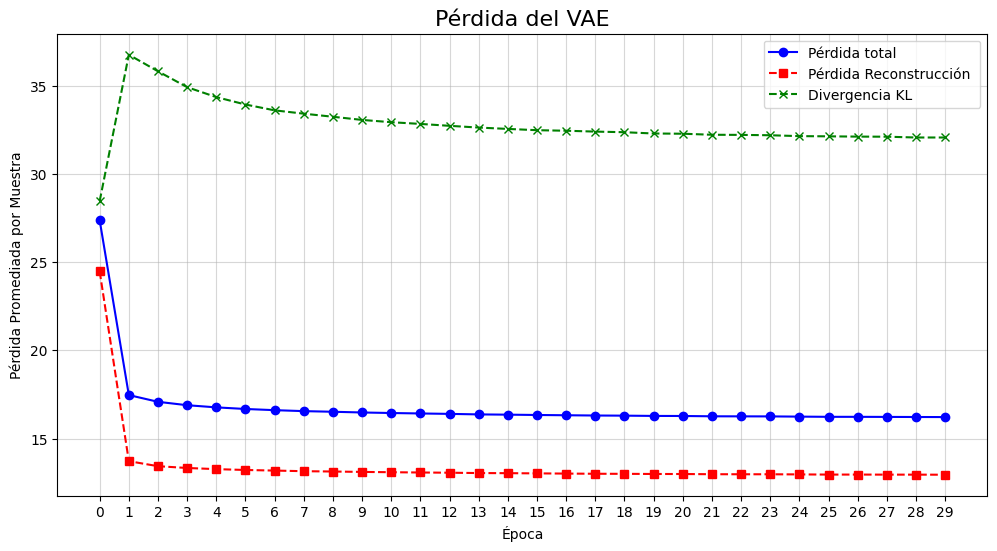

In [14]:
def plot_epoch_loss_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history['total'], label='Pérdida total', color='blue', marker='o')
    
    plt.plot(history['mse'], label='Pérdida Reconstrucción ', color='red', linestyle='--', marker='s')
    plt.plot(history['kld'], label='Divergencia KL', color='green', linestyle='--', marker='x')
    
    # Etiquetas y Título
    plt.title('Pérdida del VAE', fontsize=16)
    plt.xlabel('Época')
    plt.ylabel('Pérdida Promediada por Muestra')
    plt.xticks(range(num_epochs)) 
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

plot_epoch_loss_history(epoch_loss_history)

generar imagenes nuevas (con ruido como entrada)

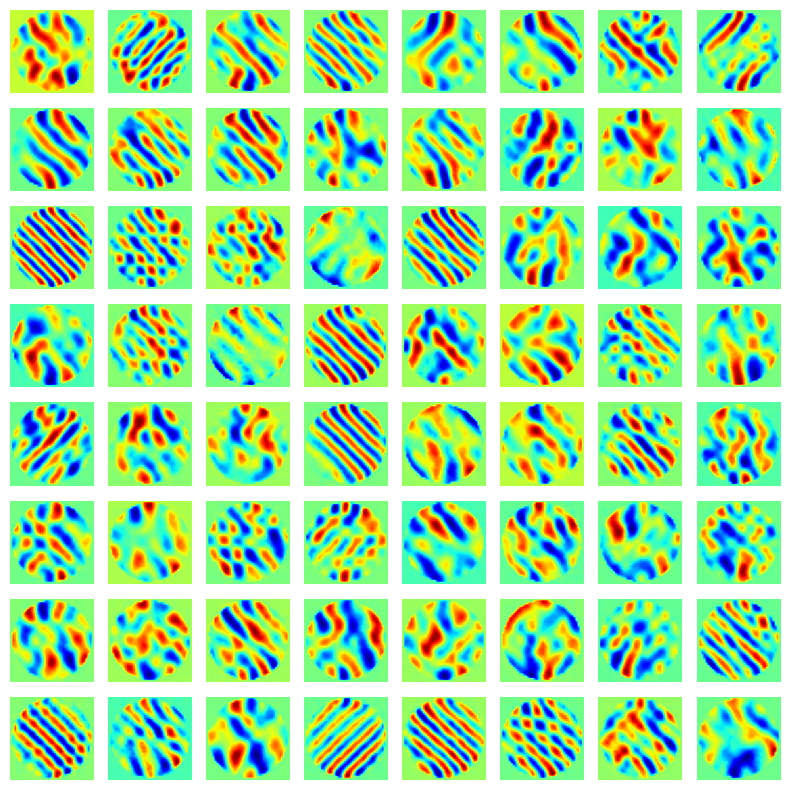

In [15]:
model.eval()
with torch.no_grad():
    z = torch.randn(64, best_params['z_dim']).to(device)
    generated = model.decode(z).cpu()

fig, axes = plt.subplots(8, 8, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i,0], cmap='jet')
    ax.axis('off')
plt.tight_layout()
plt.show()

visualización del espacio latente con umap

In [16]:
def extract_features_rapids(model, loader, device):
    model.eval()
    feats_gpu = []   
    labels_cpu = []  
    
    with torch.no_grad():
        for data, kdm, t in loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            feats_gpu.append(cp.asarray(mu.detach()))
            labels_cpu.append(kdm.numpy())

    return cp.concatenate(feats_gpu), np.concatenate(labels_cpu)

[2025-11-19 11:21:06.576] [CUML] [info] Building knn graph using nn descent


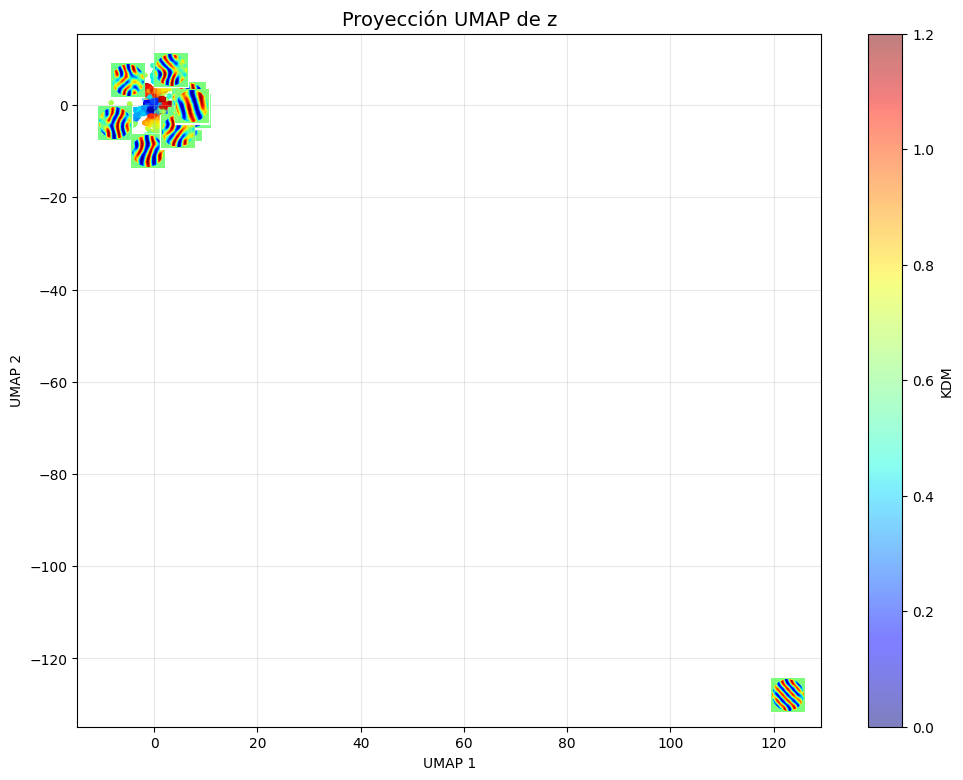

In [17]:
def plot_umap_with_images(model, data_loader, device, n_images_to_show=64, zoom=0.7):
    model.eval()
    all_z = []
    all_labels = []
    with torch.no_grad():
        for x, y, _ in data_loader:
            x = x.to(device).float()
            mu, logvar = model.encode(x)
            z = model.reparameterize(mu, logvar)
            all_z.append(z.cpu().numpy())
            all_labels.append(y.cpu().numpy())
            
    all_z = np.concatenate(all_z, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    reducer = cumlUMAP(n_components=2)
    embedding = reducer.fit_transform(all_z)
    fig, ax = plt.subplots(figsize=(12, 9))
    sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=all_labels, cmap='jet', alpha=0.5, s=5)
    plt.colorbar(sc, label='KDM')

    x_min, x_max = embedding[:, 0].min(), embedding[:, 0].max()
    y_min, y_max = embedding[:, 1].min(), embedding[:, 1].max()
    
    grid_size = int(np.sqrt(n_images_to_show))
    grid_x = np.linspace(x_min, x_max, grid_size)
    grid_y = np.linspace(y_min, y_max, grid_size)
    
    grid_points = []
    for gx in grid_x:
        for gy in grid_y:
            grid_points.append([gx, gy])
    grid_points = np.array(grid_points)

    nbrs = NearestNeighbors(n_neighbors=1).fit(embedding)
    distances, indices = nbrs.kneighbors(grid_points)
    indices = np.unique(indices.flatten())

    with torch.no_grad():
        for idx in indices:
            z_sample = torch.tensor(all_z[idx:idx+1]).to(device)
            
            img_gen = model.decode(z_sample).cpu().squeeze().numpy()
            im = OffsetImage(img_gen, zoom=zoom, cmap='jet') 
            
            ab = AnnotationBbox(im, (embedding[idx, 0], embedding[idx, 1]), 
                                frameon=True, pad=0.02, bboxprops=dict(edgecolor='white'))
            ax.add_artist(ab)
            
    plt.title('Proyección UMAP de z', fontsize=14)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_umap_with_images(model, train_loader, device, n_images_to_show=100, zoom=0.6)